# 1. Sahte Veristenin Hazırlanması

Gerekli kütüphaneleri ve paketleri yükleyelim

In [294]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 

%matplotlib inline

%config IPCompleter.greedy=True

Kendi random verisetimizi yaratalım.

In [295]:
# Gözlem sayısı
n = 1000

# Ölçüm sıklığı
t = 1

# Lokasyon sayısı
lokasyon_sayisi = 4

# Random Seed
np.random.seed(2020)

# Dictionary oluşturalım
food_dict = {'DateTime':[], 'Food_Amount_gr':[], 'Location_Id':[]}

# Timestamp başlangıç
observation_time = datetime.datetime(2020, 10, 10, 0, 0, 0, 0)
print("İlk ölçüm")
print(observation_time)

# Timedelta yaratıp döngü içerisinde ekleyeceğiz.
td = datetime. timedelta(hours = t)

# Kabın alabileceği mama miktarı gr
initial_food = 1000

# Her lokasyon için ayrı rastgele gözlemler
for l in range(lokasyon_sayisi+1):
    
    observation_time = datetime.datetime(2020, 10, 10, 0, 0, 0, 0)
    initial_food = 1000
    
    for i in range(n):

        # Gözlem saati
        food_dict['DateTime'].append(observation_time + td)

        # Varolan mama miktarını saat başı rastgele olarak 1-100gr arası azalt
        initial_food = max(initial_food - np.random.randint(20,100), 0)
        food_dict['Food_Amount_gr'].append(initial_food)

        # Lokasyon id ekle
        food_dict['Location_Id'].append(l)

        # DateTime ı güncelle
        observation_time += td

        # Eğer mama bittiyse doldur
        if initial_food == 0:
            initial_food = 1000

İlk ölçüm
2020-10-10 00:00:00


In [296]:
# pandas DataFrame objesi oluşturalım
data = pd.DataFrame.from_dict(food_dict)

Verisetini kaydedelim

In [297]:
data.to_csv("food_observation.csv", index=False)

# 2. Exploratory Data Analysis

In [298]:
# Veritesini yükle
data = pd.read_csv("food_observation.csv", parse_dates=["DateTime"])

# İlk 5 satıra göz atalım
display(data.head())

# Info
print(data.info())

# Özet istatistiklere bakalım
print(data.describe())

,DateTime,Food_Amount_gr,Location_Id
0,2020-10-10 01:00:00,972,0
1,2020-10-10 02:00:00,885,0
2,2020-10-10 03:00:00,798,0
3,2020-10-10 04:00:00,775,0
4,2020-10-10 05:00:00,684,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   DateTime        5000 non-null   datetime64[ns]
 1   Food_Amount_gr  5000 non-null   int64         
 2   Location_Id     5000 non-null   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 117.3 KB
None
       Food_Amount_gr  Location_Id
count     5000.000000  5000.000000
mean       463.207800     2.000000
std        294.558146     1.414355
min          0.000000     0.000000
25%        207.000000     1.000000
50%        461.000000     2.000000
75%        719.000000     3.000000
max        980.000000     4.000000


Lokasyonlara göre su/mama miktarının görselleştirilmesi

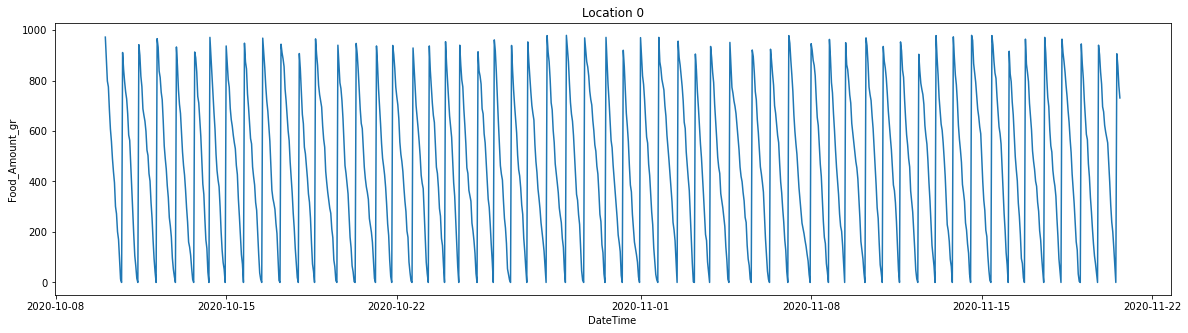

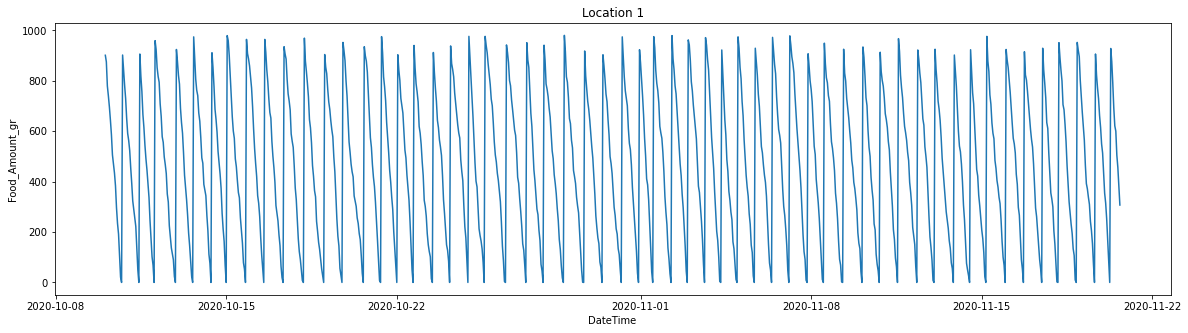

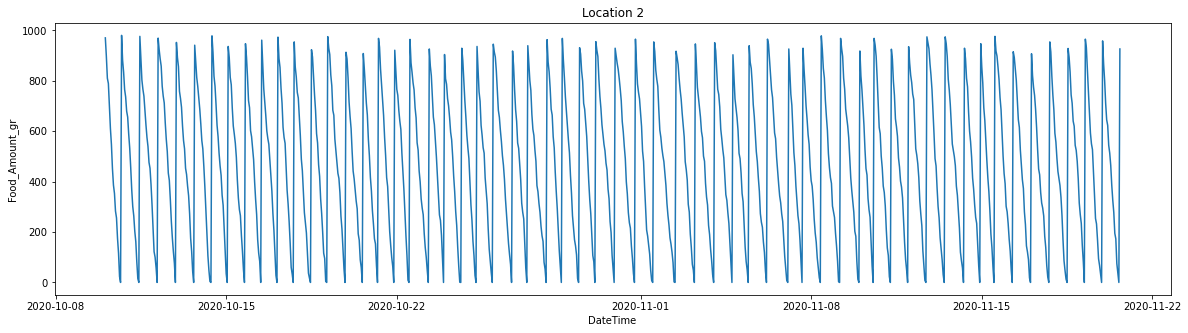

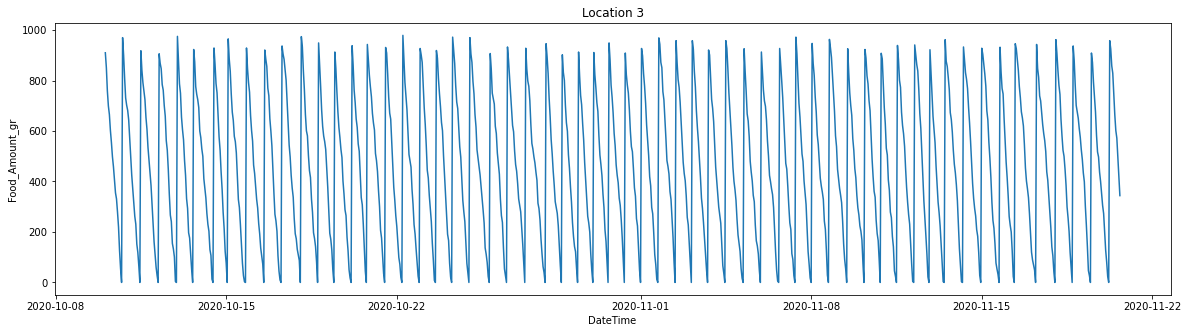

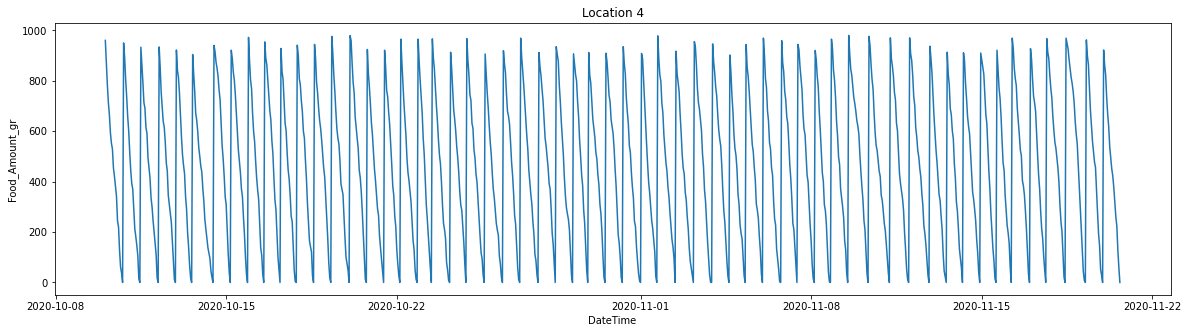

In [299]:
for i in range(lokasyon_sayisi+1):
    plt.figure(figsize = (20, 5), facecolor = None)
    plt.title("Location {}".format(i))
    sns.lineplot(x="DateTime", y="Food_Amount_gr", data=data[data["Location_Id"]==i])
    plt.show()


# 3. Feature Engineering

Elimizdeki verisetine göre mamanın bitmesine kaç saat olduğunu bağımlı değişkenimiz olmak üzere verisetine ekleyelim

In [300]:
# Kalan zamanı gösteren kolonu oluşturalım
data["Remaining_Time"] = 0

for i in range(lokasyon_sayisi+1):
    
    # Mama Miktarı sıfır olan gözlemlerin indexlerini alalım
    selected_indexes = data.index[np.logical_and(data['Food_Amount_gr'] == 0, data['Location_Id'] == i)].tolist()
    #print("LOCATION", i)
    #print("Selected", selected_indexes)
    
    initial_idx = 0
    
    for j in selected_indexes:
        for index, row in data[data["Location_Id"] == i].iterrows():
            #print("Index", index)
            #print("Selected", j)
            if index < j and index >= initial_idx:
                #print("selected", data.loc[j, "DateTime"])
                #print("now", data.loc[index, "DateTime"])
                delta = (data.loc[j, "DateTime"] - data.loc[index, "DateTime"])
                data.loc[index, "Remaining_Time"] = delta.days * 24 + delta.seconds/3600
                #print(data.loc[index, "Remaining_Time"])
                global temp
                temp = index
        initial_idx = temp
        #print("Initial_idx", initial_idx)

display(data)

,DateTime,Food_Amount_gr,Location_Id,Remaining_Time
0,2020-10-10 01:00:00,972,0,16.0
1,2020-10-10 02:00:00,885,0,15.0
2,2020-10-10 03:00:00,798,0,14.0
3,2020-10-10 04:00:00,775,0,13.0
4,2020-10-10 05:00:00,684,0,12.0
...,...,...,...,...
4995,2020-11-20 12:00:00,262,4,4.0
4996,2020-11-20 13:00:00,223,4,3.0
4997,2020-11-20 14:00:00,129,4,2.0
4998,2020-11-20 15:00:00,59,4,1.0


Son olarak One Hot Encoding ile kategorik lokasyon verisini makine öğrenmesi algoritmasına uygun hale getirelim. 

In [301]:
# get_dummies ile OHE
one_hot = pd.get_dummies(data["Location_Id"], drop_first=True)
data.drop("Location_Id", inplace=True, axis=1)
data = data.join(one_hot)

                               
# Verisetine son kez göz atalım
display(data.head())

,DateTime,Food_Amount_gr,Remaining_Time,1,2,3,4
0,2020-10-10 01:00:00,972,16.0,0,0,0,0
1,2020-10-10 02:00:00,885,15.0,0,0,0,0
2,2020-10-10 03:00:00,798,14.0,0,0,0,0
3,2020-10-10 04:00:00,775,13.0,0,0,0,0
4,2020-10-10 05:00:00,684,12.0,0,0,0,0


Verisetini kaydedelim.

In [302]:
data.to_csv("food_observation_processed.csv", index=False)

# 3. Makine Öğrenmesi

In [303]:
# Veritesini yükle
data = pd.read_csv("food_observation_processed.csv", parse_dates=["DateTime"])

Gerkli kütüphaneleri import edelim

In [304]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


Verisetini train/val/test set olarak bölelim

In [309]:
# Bağımlı ve bağımsız değişkenlerin seçimi
X = data[["Food_Amount_gr","1","2","3","4"]]
y = data["Remaining_Time"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2020) # 0.25 x 0.8 = 0.2


,Food_Amount_gr,1,2,3,4
0,972,0,0,0,0
1,885,0,0,0,0
2,798,0,0,0,0
3,775,0,0,0,0
4,684,0,0,0,0
...,...,...,...,...,...
4995,262,0,0,0,1
4996,223,0,0,0,1
4997,129,0,0,0,1
4998,59,0,0,0,1


0       16.0
1       15.0
2       14.0
3       13.0
4       12.0
        ... 
4995     4.0
4996     3.0
4997     2.0
4998     1.0
4999     0.0
Name: Remaining_Time, Length: 5000, dtype: float64

## Linear Regresyon

In [310]:

# Linear Regressoru ilklendirelim
lr = LinearRegression()

# Modeli eğitelim
lr.fit(X_train, y_train)

# Katsayıları ve intercepti inceleyelim
print("Coefficent:",lr.coef_)
print("Intercept:",lr.intercept_)


# Tahmin
y_pred_val = lr.predict(X_val)
y_pred_train = lr.predict(X_train)

# TRAINING ERRORS
print("\nTraining Errors:\n ")

# Mean Squared Error
print("MSE:",mean_squared_error(y_train, y_pred_train))

# Root Mean Squared Error
print("RMSE:",np.sqrt(mean_squared_error(y_train, y_pred_train)))
      
# R^2
print("R^2:",lr.score(X_train, y_train))


# VALIDATION ERRORS
print("\nValidation Errors:\n ")

# Mean Squared Error
print("MSE:",mean_squared_error(y_val, y_pred_val))

# Root Mean Squared Error
print("RMSE:",np.sqrt(mean_squared_error(y_val, y_pred_val)))
      
# R^2
print("R^2:",lr.score(X_val, y_val))

Coefficent: [ 0.00647735 -0.06052826 -0.22467475 -0.31298712 -0.21725897]
Intercept: 7.418636540144549

Training Errors:
 
MSE: 23.12642536106995
RMSE: 4.808994215121281
R^2: 0.13627160202686084

Validation Errors:
 
MSE: 22.7126303799913
RMSE: 4.76577699646042
R^2: 0.142220437035799


## Random Froest

In [311]:
# Hiperparametre optimizasyonu için parametreleri tutan dictionary
parameters = {'n_estimators':[100,200,300]}

# Regressoru initialize edelim.
rf = RandomForestRegressor()

# Hiperparametre optimizasyonu için GridSearchCB
search = GridSearchCV(estimator=rf, param_grid=parameters)

# Fit the grid search
search.fit(X_train, y_train.ravel())

# En iyi model ve en iyi R kare skoru
print("Best parameters:",search.best_params_)
print("Best R^2:",search.best_score_)

# Modeli Eğitelim
rf_best = search.best_estimator_



# Tahmin
y_pred_val = rf_best.predict(X_val)
y_pred_train = rf_best.predict(X_train)

# TRAINING ERRORS
print("\nTraining Errors:\n ")

# Mean Squared Error
print("MSE:",mean_squared_error(y_train, y_pred_train))

# Root Mean Squared Error
print("RMSE:",np.sqrt(mean_squared_error(y_train, y_pred_train)))
      
# R^2
print("R^2:",rf_best.score(X_train, y_train))


# VALIDATION ERRORS
print("\nValidation Errors:\n ")

# Mean Squared Error
print("MSE:",mean_squared_error(y_val, y_pred_val))

# Root Mean Squared Error
print("RMSE:",np.sqrt(mean_squared_error(y_val, y_pred_val)))
      
# R^2
print("R^2:",rf_best.score(X_val, y_val))

Best parameters: {'n_estimators': 100}
Best R^2: 0.6744107215002979

Training Errors:
 
MSE: 2.3157937505835435
RMSE: 1.5217732257414518
R^2: 0.9135094682814746

Validation Errors:
 
MSE: 7.795870927125771
RMSE: 2.792108688272319
R^2: 0.7055762082631213


## Neural Network

In [312]:
# Eğitim ve Doğrulama verisi
X_train, X_test, y_train, y_test = train_test_split(data["Food_Amount_gr"], data["Remaining_Time"], test_size=0.2, random_state=2020)

In [313]:
# Gerekli Kütüphaneleri ekleyelim
import tensorflow as tf

from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [ ]:
# Modeli Oluşturalım
model = Sequential()
model.add(Dense(12, input_dim=1, kernel_initializer='normal', activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

# Model Özeti
model.summary()

# Compile edelim
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

# Eğitim
history = model.fit(X_train, y_train, epochs=150, batch_size=50,  verbose=1, validation_split=0.2)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 12)                24        
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 137
Trainable params: 137
Non-trainable params: 0
_________________________________________________________________
Train on 3200 samples, validate on 800 samples
Epoch 1/150
3200/3200 [==============================] - 0s 137us/sample - loss: 74.1664 - mse: 74.1664 - mae: 5.3014 - val_loss: 41.9603 - val_mse: 41.9603 - val_mae: 3.2148
Epoch 2/150
3200/3200 [==============================] - 0s 50us/sample - loss: 36.3009 - mse: 36.3009 - mae: 2.8092 - val_loss: 41.2059 - val_mse: 41.2059 - val_ma

3200/3200 [==============================] - 0s 49us/sample - loss: 16.8423 - mse: 16.8423 - mae: 3.1095 - val_loss: 17.4476 - val_mse: 17.4476 - val_mae: 3.1520
Epoch 44/150
3200/3200 [==============================] - 0s 50us/sample - loss: 16.3394 - mse: 16.3394 - mae: 3.0890 - val_loss: 16.6490 - val_mse: 16.6490 - val_mae: 3.1048
Epoch 45/150
3200/3200 [==============================] - 0s 63us/sample - loss: 15.4129 - mse: 15.4129 - mae: 2.9951 - val_loss: 15.9252 - val_mse: 15.9252 - val_mae: 3.0502
Epoch 46/150
3200/3200 [==============================] - 0s 50us/sample - loss: 14.7018 - mse: 14.7018 - mae: 2.9199 - val_loss: 14.9457 - val_mse: 14.9457 - val_mae: 2.9315
Epoch 47/150
3200/3200 [==============================] - 0s 49us/sample - loss: 14.1024 - mse: 14.1024 - mae: 2.8585 - val_loss: 14.8325 - val_mse: 14.8325 - val_mae: 2.9911
Epoch 48/150
3200/3200 [==============================] - 0s 48us/sample - loss: 13.6200 - mse: 13.6200 - mae: 2.8285 - val_loss: 14.5655 

Epoch 91/150
3200/3200 [==============================] - 0s 66us/sample - loss: 6.5586 - mse: 6.5586 - mae: 1.4811 - val_loss: 6.3367 - val_mse: 6.3367 - val_mae: 1.5077
Epoch 92/150
3200/3200 [==============================] - 0s 55us/sample - loss: 6.5516 - mse: 6.5516 - mae: 1.4856 - val_loss: 6.4652 - val_mse: 6.4652 - val_mae: 1.4536
Epoch 93/150
3200/3200 [==============================] - 0s 51us/sample - loss: 6.6004 - mse: 6.6004 - mae: 1.4746 - val_loss: 6.5617 - val_mse: 6.5617 - val_mae: 1.5463
Epoch 94/150
3200/3200 [==============================] - 0s 52us/sample - loss: 6.6075 - mse: 6.6075 - mae: 1.4900 - val_loss: 6.7467 - val_mse: 6.7467 - val_mae: 1.5164
Epoch 95/150
3200/3200 [==============================] - 0s 55us/sample - loss: 6.5165 - mse: 6.5165 - mae: 1.4777 - val_loss: 6.4978 - val_mse: 6.4978 - val_mae: 1.4372
Epoch 96/150
3200/3200 [==============================] - 0s 49us/sample - loss: 6.5347 - mse: 6.5347 - mae: 1.4639 - val_loss: 6.4421 - val_mse:

In [ ]:
# Modeli kaydedelim
with open("model.json", "w") as json_file: 
    json_file.write(model.to_json())
    
# Model ağırlıklarını kaydedelim
model.save_weights("weights.h5") 